# Imports

In [1]:
import ray
from ray.actor import ActorHandle
from typing import Tuple
from asyncio import Event
import sys 
import cv2
import time
import logging
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt 
import gc
import traceback
import matplotlib.lines as mlines

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.patches as mpatches
from tqdm.auto import tqdm, trange
from scipy.signal import medfilt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from pathlib import Path
sys.path.append(str(Path('.').absolute().parent.parent))
# sys.path.append(str(Path('~/Research/MyRepos/SensoryMotorPred/PredCoding/').expanduser()))
# from util.paths import find, list_subdirs
# import io_dict_to_hdf5 as ioh5
from util.log import log



import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False, 
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import platform
if platform.system() == 'Linux':
    # base_path = Path('~/NewMonster/T/BinocOptoPreyCapture/').expanduser()
    base_path = Path('/mnt/t/BinocOptoPreyCapture')
    print('Running on Linux')
else:
    base_path = Path('T:/BinocOptoPreyCapture').expanduser()
    print('Running on Windows')

url = ray.init(  # address='auto',
    include_dashboard=True,
    ignore_reinit_error=True,
    logging_level=logging.ERROR,)
print(url)
# log_path = base_path/'batch_log_anim.txt'
# logf = log(log_path, name=['Starting Recording'])
# # logging.basicConfig(filename=log_path, level=logging.DEBUG)
# logf.log(url, PRINT=True)

Running on Linux
{'node_ip_address': '172.27.33.156', 'raylet_ip_address': '172.27.33.156', 'redis_address': '172.27.33.156:6379', 'object_store_address': '/tmp/ray/session_2021-10-20_09-14-17_196290_12169/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-10-20_09-14-17_196290_12169/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2021-10-20_09-14-17_196290_12169', 'metrics_export_port': 65040, 'node_id': '2680d09a046194887cd033d5ba1b238f35edc689d7479dab56fe9dfb'}


In [2]:

# ProgressBar
@ray.remote
class ProgressBarActor:
    counter: int
    delta: int
    event: Event

    def __init__(self) -> None:
        self.counter = 0
        self.delta = 0
        self.event = Event()

    def update(self, num_items_completed: int) -> None:
        """Updates the ProgressBar with the incremental
        number of items that were just completed.
        """
        self.counter += num_items_completed
        self.delta += num_items_completed
        self.event.set()

    async def wait_for_update(self) -> Tuple[int, int]:
        """Blocking call.

        Waits until somebody calls `update`, then returns a tuple of
        the number of updates since the last call to
        `wait_for_update`, and the total number of completed items.
        """
        await self.event.wait()
        self.event.clear()
        saved_delta = self.delta
        self.delta = 0
        return saved_delta, self.counter

    def get_counter(self) -> int:
        """
        Returns the total number of complete items.
        """
        return self.counter


class ProgressBar:
    progress_actor: ActorHandle
    total: int
    description: str
    pbar: tqdm

    def __init__(self, total: int, description: str = ""):
        # Ray actors don't seem to play nice with mypy, generating
        # a spurious warning for the following line,
        # which we need to suppress. The code is fine.
        self.progress_actor = ProgressBarActor.remote()  # type: ignore
        self.total = total
        self.description = description

    @property
    def actor(self) -> ActorHandle:
        """Returns a reference to the remote `ProgressBarActor`.

        When you complete tasks, call `update` on the actor.
        """
        return self.progress_actor

    def print_until_done(self) -> None:
        """Blocking call.

        Do this after starting a series of remote Ray tasks, to which you've
        passed the actor handle. Each of them calls `update` on the actor.
        When the progress meter reaches 100%, this method returns.
        """
        pbar = tqdm(desc=self.description, total=self.total)
        while True:
            delta, counter = ray.get(self.actor.wait_for_update.remote())
            pbar.update(delta)
            if counter >= self.total:
                pbar.close()
                return


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def add_colorbar(mappable, linewidth=2):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    cbar.outline.set_linewidth(linewidth)
    plt.sca(last_axes)
    return cbar


    
cmap_name = 'Accent'
########## Checks if path exists, if not then creates directory ##########
def check_path(basepath, path):
    ''' Created by Elliott Abe '''
    if path in basepath.as_posix():
        return basepath
    elif not (basepath / path).exists():
        (basepath / path).mkdir(exist_ok=True,parents=True)
        print('Added Directory:'+ (basepath / path).as_posix())
        return (basepath / path)
    else:
        return (basepath / path)


def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def add_colorbar(mappable,linewidth=2):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    cbar.outline.set_linewidth(linewidth)
    plt.sca(last_axes)
    return cbar

cmap_name = 'Accent'

def get_laser_onoff(imufile,laser_ksize=3):
    imu_data = xr.open_dataset(imufile)
    LaserT = imu_data.IMU_data.sample.data # imu timestamps
    LaserT0 = LaserT[0]
    LaserT = LaserT - LaserT0
    laser = imu_data.IMU_data.sel(channel='acc_x_raw').data # imu dample data
    dlaser = np.diff(medfilt(laser, kernel_size=laser_ksize),append=0)
    l_inds = np.where((np.abs(dlaser)>1.5))[0]
    LOn_ind = l_inds[0]
    LOff_ind = l_inds[-1]
    return LOn_ind, LOff_ind, LaserT


In [3]:

@ray.remote
def make_plt_im(tvid, ang_norm, spd_norm, dist_norm, patches, Vid1, Vid2, pts1, pts2, clim, metrics, asd, t, fname, LaserOnOffT, npts1=16, nbins=10): #pbar: ActorHandle,
    fig2 = plt.figure(constrained_layout=False, figsize=(15, 15))
    spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
    axs1 = fig2.add_subplot(spec2[0, :])
    inner_grid = gridspec.GridSpecFromSubplotSpec(1,4, spec2[1:3,:])
    axs2a = fig2.add_subplot(inner_grid[0, :2])
    axs2b = fig2.add_subplot(inner_grid[0, 2:])
    axs3 = np.array([fig2.add_subplot(spec2[3, n]) for n in range(3)])
    width, height = fig2.get_size_inches() * fig2.get_dpi()
    # canvas = FigureCanvas(fig2)
    # Plotting Angle, Speed, Dist
    p1 = axs1.scatter(tvid, ang_norm, 3, c='b',)
    p2 = axs1.plot(tvid, spd_norm, c='k')
    p3 = axs1.plot(tvid, dist_norm, c='m')
    axs1.axvline(x=LaserOnOffT[0],c='g',linestyle='--')
    axs1.axvline(x=LaserOnOffT[1],c='r',linestyle='--')
    axs1.legend(handles=patches, labels=['Angle', 'Speed', 'Dist','LaserOn','LaserOff'], loc='upper right', bbox_to_anchor=(1.01, 1), fontsize=10)
    axs1.axhline(y=0, c='k', linestyle='--')
    axs1.set_title(fname)
    axs1.axvline(x=tvid[t], c='b', linestyle='-')
    axs1.set_xlabel('Time (s)')

    
    # Image Frame and DLC Tracking
    axs2a.imshow(Vid1[t], cmap='gray')
    axs2a.scatter(pts1[0, t], pts1[1, t], c=np.arange(npts1-1, -1, -1), cmap=cmap)
    axs2b.imshow(Vid2[t], cmap='gray')
    axs2b.scatter(pts2[0, t], pts2[1, t], c=np.arange(npts1-1, -1, -1), cmap=cmap)

    # 2d hist of Angle, Speed, Dist.
    for n in range(perms.shape[0]):
        h_on, xbins_on, ybins_on, im_on, = axs3[n].hist2d(hist_data_Lon[metrics[perms[n, 0]]], hist_data_Lon[metrics[perms[n, 1]]], bins=nbins, density=True, vmin=clim[n, 0], vmax=clim[n, 1])
        axs3[n].set_xlabel(metrics[perms[n, 0]])
        axs3[n].set_ylabel(metrics[perms[n, 1]])
        axs3[n].set_title('LOn:{},{}'.format(
            LaserOn, df_trial['Exp_Ctrl']), fontsize=20)
        if np.isnan(asd[perms[n], t]).any() != True:
            try:
                xpt = xbins_on[np.digitize(asd[perms[n, 0], t], xbins_on)]+np.mean(np.diff(xbins_on))/2
                ypt = ybins_on[np.digitize(asd[perms[n, 1], t], ybins_on)]+np.mean(np.diff(ybins_on))/2
                axs3[n].scatter(xpt, ypt, 200, 'r')
            except Exception as e:
                print(e)
    plt.tight_layout()
    fig2.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig2.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    plt.close()
    # pbar.update.remote(1)
    return images

# Start Data Loading

In [4]:

SavePath = check_path(base_path.expanduser(),'Data')
df_meta = pd.read_feather(SavePath/'df_meta.feather')
df_all = pd.read_feather(SavePath/'df_all.feather')
df_all = df_all.set_index(['experiment_date','animal_name','Trial'])
df = df_all.dropna()
FigPath = check_path(base_path.expanduser(),'Figures/')
print(FigPath)
green_dotted_line = mlines.Line2D([], [], linewidth=2, linestyle="--", dashes=(3.7, 2), color='green')
red_dotted_line = mlines.Line2D([], [], linewidth=2, linestyle="--", dashes=(3.7, 2), color='red')
blue_patch = mpatches.Patch(color='blue', label='Angle')
black_patch = mpatches.Patch(color='black', label='Speed')
m_patch = mpatches.Patch(color='m', label='Dist')
patches = [blue_patch, black_patch, m_patch,green_dotted_line, red_dotted_line]
metrics = ['Angle','Speed','Dist']
perms = np.array(list(itertools.combinations(np.arange(len(metrics)), 2)))
order=['Wno','Lno','Hno','Wsw','Wlb','Wsb','Lsb','Hsb',]


##### Histogram data #####
print('2d Historgrams')
h2dbins=10
hist_data_all = np.zeros((h2dbins,h2dbins,2,2,perms.shape[0],len(order)))# (bin x bin x Exp x LaserOn x Comb x Env)
xedges_all = np.zeros((h2dbins+1,2,2,perms.shape[0],len(order)))# (bin x Exp x LaserOn x Comb x Env)
yedges_all = np.zeros((h2dbins+1,2,2,perms.shape[0],len(order)))# (bin x Exp x LaserOn x Comb x Env)
for en, env in enumerate(tqdm(order, leave=False)):
    for n in range(perms.shape[0]):
        for m, Exp in enumerate([True,False]):
            hist_data_Lon =df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==True) & (df['Environment']==env)].reset_index()
            hist_data_Loff = df[['Angle','Speed','Dist','Environment','LaserOn']][(df['ExpAni']==Exp) & (df['LaserOn']==False) & (df['Environment']==env)].reset_index()
            H_on,xedges_on,yedges_on = np.histogram2d(hist_data_Lon[metrics[perms[n,0]]],hist_data_Lon[metrics[perms[n,1]]],bins=h2dbins, density=True)
            H_off,xedges_off,yedges_off = np.histogram2d(hist_data_Loff[metrics[perms[n,0]]],hist_data_Loff[metrics[perms[n,1]]],bins=10, density=True)
            hist_data_all[:,:,0,m,n,en] = H_on
            hist_data_all[:,:,1,m,n,en] = H_off
            xedges_all[:,0,m,n,en] = xedges_on
            xedges_all[:,1,m,n,en] = xedges_off
            yedges_all[:,0,m,n,en] = yedges_on
            yedges_all[:,1,m,n,en] = yedges_off


/mnt/t/BinocOptoPreyCapture/Figures
2d Historgrams


  0%|          | 0/8 [00:00<?, ?it/s]

In [5]:

for n in tqdm(np.arange(128,df_meta.shape[0])):
    ##### Extract Values from DataFrames #####
    trial = df_meta['Trial'].iloc[n]
    date = df_meta['experiment_date'].iloc[n]
    ani = df_meta['animal_name'].iloc[n]
    lon = df_meta['LaserOnInd'].iloc[n]
    loff = df_meta['LaserOffInd'].iloc[n]
    print('{}, {}, {}, {}'.format(n, date, ani, trial))
    ang_norm = df_all.xs((date, ani, trial), level=(0, 1, 2))['Angle_norm'].values
    spd_norm = df_all.xs((date, ani, trial), level=(0, 1, 2))['Speed_norm'].values
    dist_norm = df_all.xs((date, ani, trial), level=(0, 1, 2))['Dist_norm'].values
    ang = df_all.xs((date, ani, trial), level=(0, 1, 2))['Angle'].values
    spd = df_all.xs((date, ani, trial), level=(0, 1, 2))['Speed'].values
    dist = df_all.xs((date, ani, trial), level=(0, 1, 2))['Dist'].values
    asd = np.vstack((ang, spd, dist))
    asd_norm = np.vstack((ang_norm, spd_norm, dist_norm))
    tvid = df_all.xs((date, ani, trial), level=(0, 1, 2))['t'].values
    df_trial = df_meta[((df_meta['experiment_date'] == date) & (df_meta['animal_name'] == ani) & (df_meta['Trial'] == trial))].iloc[0]
    Exp = True if df_trial['Exp_Ctrl'] == 'Exp' else False
    LaserOn = df_trial['LaserOn']
    Env = df_trial['Environment']
    LaserOnOffT = np.hstack((df_trial['LaserOnT'], df_trial['LaserOffT']))
    # df_trial[['animal_name','experiment_date','Trial','CaptureT','MovieT','LaserOnT','LaserOffT','LaserOn','Environment','Exp_Ctrl','Capture','Cap_dur_laser']]

    ##### Grab Video and h5 files #####
    fname1 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP1.avi'))[0])
    fname2 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP2.avi'))[0])
    fname_h51 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP1*.h5'))[0])
    fname_h52 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP2*.h5'))[0])


    ##### Read h5 DLC Points #####
    pts1 = pd.read_hdf(fname_h51)
    pts1.columns = [' '.join(col[:][1:3]).strip() for col in pts1.columns.values]
    pts1 = pts1.rename(columns={pts1.columns[n]: pts1.columns[n].replace(' ', '_') for n in range(len(pts1.columns))})
    pt_loc_names = pts1.columns.values
    npts1 = len(pts1.iloc[0, ::3])
    cmap = mpl.cm.get_cmap('jet', npts1)    # 16 discrete colors

    ##### Nan out low LL points #####
    thresh = .99
    for n, key in enumerate(list(pts1.keys()[2::3])):
        lowLL = (pts1[key] < .99)
        pts1[key.split('_')[0] + '_x'].loc[pts1[key] < thresh] = np.nan
        pts1[key.split('_')[0] + '_y'].loc[pts1[key] < thresh] = np.nan

    ##### Read h5 DLC Points #####
    pts2 = pd.read_hdf(fname_h52)
    pts2.columns = [' '.join(col[:][1:3]).strip() for col in pts2.columns.values]
    pts2 = pts2.rename(columns={pts2.columns[n]: pts2.columns[n].replace(' ', '_') for n in range(len(pts2.columns))})
    pt_loc_names = pts2.columns.values
    npts1 = len(pts2.iloc[0, ::3])
    cmap = mpl.cm.get_cmap('jet', npts1)    # 16 discrete colors

    ##### Nan out low LL points #####
    thresh = .99
    for n, key in enumerate(list(pts2.keys()[2::3])):
        lowLL = (pts2[key] < .99)
        pts2[key.split('_')[0] + '_x'].loc[pts2[key] < thresh] = np.nan
        pts2[key.split('_')[0] + '_y'].loc[pts2[key] < thresh] = np.nan
        

    ##### Load video frames, down sample #####
    cap = cv2.VideoCapture(fname1)
    downsamp = 0.5
    width = int(downsamp*cap.get(3))
    height = int(downsamp*cap.get(4))
    totalframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    Vid1 = np.zeros((totalframes, height, width), dtype=np.uint8)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Check if camera opened successfully
    if (cap.isOpened() == False):
        print("Error opening video stream or file: " + fname1)

    # Read until video is completed
    for t in np.arange(0, totalframes):
        # Capture frame-by-frame
        ret, frame_temp = cap.read()
        Vid1[t, :, :] = cv2.resize(cv2.cvtColor(frame_temp, cv2.COLOR_BGR2GRAY), (width, height))

    # When everything done, release the video capture object
    cap.release()


    ##### Load video frames, down sample #####
    cap = cv2.VideoCapture(fname2)
    downsamp = 0.5
    width = int(downsamp*cap.get(3))
    height = int(downsamp*cap.get(4))
    totalframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    Vid2 = np.zeros((totalframes, height, width), dtype=np.uint8)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Check if camera opened successfully
    if (cap.isOpened() == False):
        print("Error opening video stream or file: " + fname2)

    # Read until video is completed
    for t in np.arange(0, totalframes):
        # Capture frame-by-frame
        ret, frame_temp = cap.read()
        Vid2[t, :, :] = cv2.resize(cv2.cvtColor(frame_temp, cv2.COLOR_BGR2GRAY), (width, height))

    # When everything done, release the video capture object
    cap.release()

    en = np.where(Env in order)[0]
    clim = np.vstack([(hist_data_all[:, :, :, :, n, :].min(), hist_data_all[:, :, :, :, n, :].max()) for n in range(perms.shape[0])])
    hist_data_Lon = df[['Angle', 'Speed', 'Dist', 'Environment', 'LaserOn']][(df['ExpAni'] == Exp) & (df['LaserOn'] == LaserOn) & (df['Environment'] == Env)].reset_index()
    pts1_xy = np.stack((pts1.iloc[:, ::3]*downsamp, pts1.iloc[:, 1::3]*downsamp))
    pts2_xy = np.stack((pts2.iloc[:, ::3]*downsamp, pts2.iloc[:, 1::3]*downsamp))

    # Put data into shared memory for parallization
    # print('Making Animation {}'.format(fname1.split('/')[-1][:-9]))
    start = time.time()
    num_ticks = np.min((Vid1.shape[0],Vid2.shape[0]))
    # pb = ProgressBar(num_ticks)
    # actor = pb.actor
    tvid_r = ray.put(tvid)
    ang_norm_r = ray.put(ang_norm)
    spd_norm_r = ray.put(spd_norm)
    dist_norm_r = ray.put(dist_norm)
    Vid1_r = ray.put(Vid1)
    Vid2_r = ray.put(Vid2)
    pts1_r = ray.put(pts1_xy)
    pts2_r = ray.put(pts2_xy)
    df_r = ray.put(df)
    asd_r = ray.put(asd)
    result_ids = []
    # Loop over parameters appending process ids
    for t in range(num_ticks):
        result_ids.append(make_plt_im.remote(tvid_r, ang_norm_r, spd_norm_r, dist_norm_r,patches, Vid1_r, Vid2_r, pts1_r, pts2_r, clim, metrics, asd_r, t, fname1.split('/')[-1][:-9], LaserOnOffT))

    # print('N_proc:', len(result_ids))
    # pb.print_until_done()
    results_p = ray.get(result_ids)

    ##### Gather Data and Find Max CC Model #####
    images = np.stack([results_p[i] for i in range(len(results_p))])
    # Example Frames Video
    aniname = fname1.split('/')[-1][:-4] + '_summary.mp4'
    # print(aniname)
    vid_name = FigPath / aniname
    # print('Writin g Video: {}'.format(vid_name))
    FPS = 60
    out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

    for fm in range(images.shape[0]):
        out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
    out.release()
    print('Making Animation {}: {}'.format(fname1.split('/')[-1][:-9], time.time()-start))
    del results_p, tvid_r, ang_norm_r, spd_norm_r, dist_norm_r, Vid1_r, pts1_r, Vid2_r, pts2_r, df_r, asd_r, images
    gc.collect()

  0%|          | 0/1177 [00:00<?, ?it/s]

128, 082721, PV154pink, 4


# Testing and Checking Plots

In [8]:
nbins = 10
npts1 = 16
n = 1
##### Extract Values from DataFrames #####
trial = df_meta['Trial'].iloc[n]
date = df_meta['experiment_date'].iloc[n]
ani = df_meta['animal_name'].iloc[n]
lon = df_meta['LaserOnInd'].iloc[n]
loff = df_meta['LaserOffInd'].iloc[n]
print('{}, {}, {}, {}'.format(n, date, ani, trial))
ang_norm = df_all.xs((date, ani, trial), level=(0, 1, 2))['Angle_norm'].values
spd_norm = df_all.xs((date, ani, trial), level=(0, 1, 2))['Speed_norm'].values
dist_norm = df_all.xs((date, ani, trial), level=(0, 1, 2))['Dist_norm'].values
ang = df_all.xs((date, ani, trial), level=(0, 1, 2))['Angle'].values
spd = df_all.xs((date, ani, trial), level=(0, 1, 2))['Speed'].values
dist = df_all.xs((date, ani, trial), level=(0, 1, 2))['Dist'].values
asd = np.vstack((ang, spd, dist))
asd_norm = np.vstack((ang_norm, spd_norm, dist_norm))
tvid = df_all.xs((date, ani, trial), level=(0, 1, 2))['t'].values
df_trial = df_meta[((df_meta['experiment_date'] == date) & (
    df_meta['animal_name'] == ani) & (df_meta['Trial'] == trial))].iloc[0]
Exp = True if df_trial['Exp_Ctrl'] == 'Exp' else False
LaserOn = df_trial['LaserOn']
Env = df_trial['Environment']

# df_trial[['animal_name','experiment_date','Trial','CaptureT','MovieT','LaserOnT','LaserOffT','LaserOn','Environment','Exp_Ctrl','Capture','Cap_dur_laser']]
##### Grab Video and h5 files #####
fname1 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP1.avi'))[0])
fname2 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP2.avi'))[0])
fname_h51 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP1*.h5'))[0])
fname_h52 = str(list((base_path / df_trial['experiment_date'] / df_trial['animal_name'] / '{:d}'.format(df_trial['Trial'])).glob('*TOP2*.h5'))[0])

##### Read h5 DLC Points #####
pts1 = pd.read_hdf(fname_h51)
pts1.columns = [' '.join(col[:][1:3]).strip() for col in pts1.columns.values]
pts1 = pts1.rename(columns={pts1.columns[n]: pts1.columns[n].replace(' ', '_') for n in range(len(pts1.columns))})
pt_loc_names = pts1.columns.values
npts1 = len(pts1.iloc[0, ::3])
cmap = mpl.cm.get_cmap('jet', npts1)    # 16 discrete colors

##### Nan out low LL points #####
thresh = .99
for n, key in enumerate(list(pts1.keys()[2::3])):
    lowLL = (pts1[key] < .99)
    pts1[key.split('_')[0] + '_x'].loc[pts1[key] < thresh] = np.nan
    pts1[key.split('_')[0] + '_y'].loc[pts1[key] < thresh] = np.nan

##### Read h5 DLC Points #####
pts2 = pd.read_hdf(fname_h52)
pts2.columns = [' '.join(col[:][1:3]).strip() for col in pts2.columns.values]
pts2 = pts2.rename(columns={pts2.columns[n]: pts2.columns[n].replace(' ', '_') for n in range(len(pts2.columns))})
pt_loc_names = pts2.columns.values
npts1 = len(pts2.iloc[0, ::3])
cmap = mpl.cm.get_cmap('jet', npts1)    # 16 discrete colors

##### Nan out low LL points #####
thresh = .99
for n, key in enumerate(list(pts2.keys()[2::3])):
    lowLL = (pts2[key] < .99)
    pts2[key.split('_')[0] + '_x'].loc[pts2[key] < thresh] = np.nan
    pts2[key.split('_')[0] + '_y'].loc[pts2[key] < thresh] = np.nan
    

##### Load video frames, down sample #####
cap = cv2.VideoCapture(fname1)
downsamp = 0.5
width = int(downsamp*cap.get(3))
height = int(downsamp*cap.get(4))
totalframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
Vid1 = np.zeros((totalframes, height, width), dtype=np.uint8)
fps = cap.get(cv2.CAP_PROP_FPS)

# Check if camera opened successfully
if (cap.isOpened() == False):
    print("Error opening video stream or file: " + fname1)

# Read until video is completed
for t in tqdm(np.arange(0, totalframes),leave=False):
    # Capture frame-by-frame
    ret, frame_temp = cap.read()
    Vid1[t, :, :] = cv2.resize(cv2.cvtColor(frame_temp, cv2.COLOR_BGR2GRAY), (width, height))

# When everything done, release the video capture object
cap.release()


##### Load video frames, down sample #####
cap = cv2.VideoCapture(fname2)
downsamp = 0.5
width = int(downsamp*cap.get(3))
height = int(downsamp*cap.get(4))
totalframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
Vid2 = np.zeros((totalframes, height, width), dtype=np.uint8)
fps = cap.get(cv2.CAP_PROP_FPS)

# Check if camera opened successfully
if (cap.isOpened() == False):
    print("Error opening video stream or file: " + fname2)

# Read until video is completed
for t in tqdm(np.arange(0, totalframes),leave=False):
    # Capture frame-by-frame
    ret, frame_temp = cap.read()
    Vid2[t, :, :] = cv2.resize(cv2.cvtColor(frame_temp, cv2.COLOR_BGR2GRAY), (width, height))

# When everything done, release the video capture object
cap.release()

en = np.where(Env in order)[0]
clim = np.vstack([(hist_data_all[:, :, :, :, n, :].min(), hist_data_all[:, :, :, :, n, :].max()) for n in range(perms.shape[0])])
hist_data_Lon = df[['Angle', 'Speed', 'Dist', 'Environment', 'LaserOn']][(df['ExpAni'] == Exp) & (df['LaserOn'] == LaserOn) & (df['Environment'] == Env)].reset_index()
pts1_xy = np.stack((pts1.iloc[:, ::3]*downsamp, pts1.iloc[:, 1::3]*downsamp))
pts2_xy = np.stack((pts2.iloc[:, ::3]*downsamp, pts2.iloc[:, 1::3]*downsamp))


1, 082521, PVCha2black, 2


  0%|          | 0/3673 [00:00<?, ?it/s]

  0%|          | 0/3668 [00:00<?, ?it/s]

((3673, 270, 360), (3668, 270, 360))

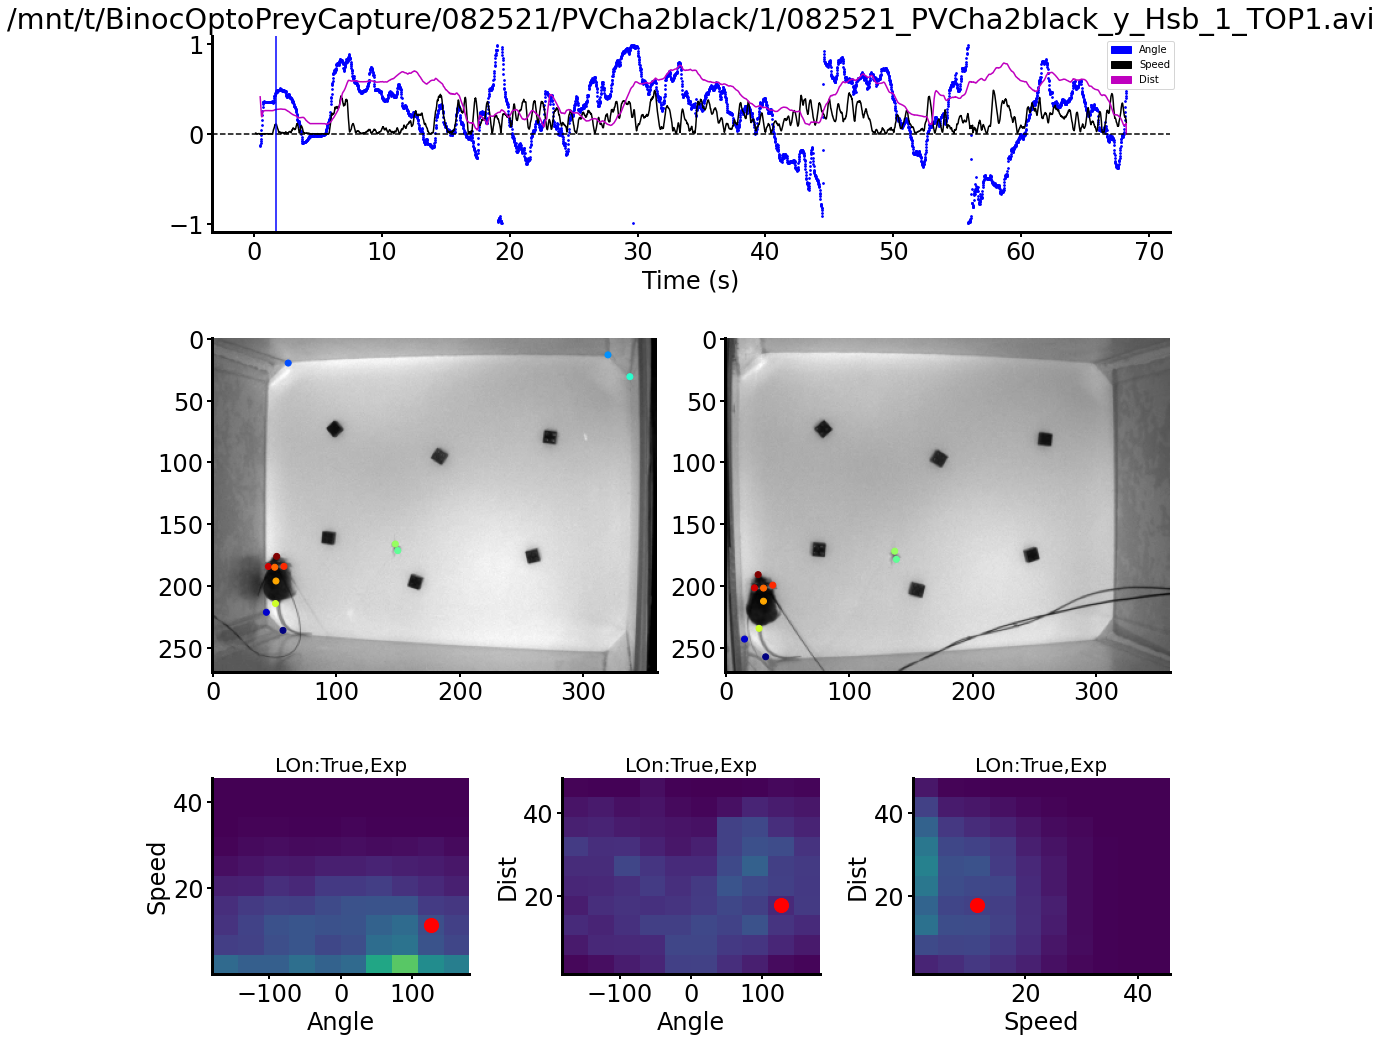

In [14]:

t = 100
fig2 = plt.figure(constrained_layout=False, figsize=(15, 15))
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig2)
axs1 = fig2.add_subplot(spec2[0, :])
inner_grid = gridspec.GridSpecFromSubplotSpec(1,4, spec2[1:3,:])
axs2a = fig2.add_subplot(inner_grid[0, :2])
axs2b = fig2.add_subplot(inner_grid[0, 2:])
axs3 = np.array([fig2.add_subplot(spec2[3, n]) for n in range(3)])
width, height = fig2.get_size_inches() * fig2.get_dpi()
# canvas = FigureCanvas(fig2)
# Plotting Angle, Speed, Dist
p1 = axs1.scatter(tvid, ang_norm, 3, c='b',)
p2 = axs1.plot(tvid, spd_norm, c='k')
p3 = axs1.plot(tvid, dist_norm, c='m')
axs1.legend(handles=patches, labels=[
            'Angle', 'Speed', 'Dist'], loc='upper right', bbox_to_anchor=(1.01, 1), fontsize=10)
axs1.axhline(y=0, c='k', linestyle='--')
axs1.set_title(fname1)
axs1.axvline(x=tvid[t], c='b', linestyle='-')
axs1.set_xlabel('Time (s)')

# Image Frame and DLC Tracking
axs2a.imshow(Vid1[t], cmap='gray')
axs2a.scatter(pts1_xy[0, t], pts1_xy[1, t], c=np.arange(npts1-1, -1, -1), cmap=cmap)
axs2b.imshow(Vid2[t], cmap='gray')
axs2b.scatter(pts2_xy[0, t], pts2_xy[1, t], c=np.arange(npts1-1, -1, -1), cmap=cmap)

# 2d hist of Angle, Speed, Dist.
for n in range(perms.shape[0]):
    h_on, xbins_on, ybins_on, im_on, = axs3[n].hist2d(hist_data_Lon[metrics[perms[n, 0]]], hist_data_Lon[metrics[perms[n, 1]]], bins=nbins, density=True, vmin=clim[n, 0], vmax=clim[n, 1])
    axs3[n].set_xlabel(metrics[perms[n, 0]])
    axs3[n].set_ylabel(metrics[perms[n, 1]])
    axs3[n].set_title('LOn:{},{}'.format(
        LaserOn, df_trial['Exp_Ctrl']), fontsize=20)
    if np.isnan(asd[perms[n], t]).any() != True:
        xpt = xbins_on[np.digitize(asd[perms[n, 0], t], xbins_on)]+np.mean(np.diff(xbins_on))/2
        ypt = ybins_on[np.digitize(asd[perms[n, 1], t], ybins_on)]+np.mean(np.diff(ybins_on))/2
        axs3[n].scatter(xpt, ypt, 200, 'r')
plt.tight_layout()
fig2.canvas.draw()       # draw the canvas, cache the renderer
images = np.frombuffer(fig2.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)


In [19]:
plt.imshow(images)
plt.show()